In [ ]:
%cd /content/drive/MyDrive/lakehead/courses/Big data course/project/data

/content/drive/MyDrive/lakehead/courses/Big data course/project/data


In [ ]:
%%capture
!pip install shap

# Imports, Definitions & Functions

In [ ]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import os
import sys


from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from sklearn.feature_selection import mutual_info_classif 

from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb 
from sklearn.metrics import roc_curve, auc, roc_auc_score

import seaborn as sns 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, auc, RocCurveDisplay, precision_recall_curve, average_precision_score

In [ ]:

old_x_features = ['cough','fever','sore_throat','shortness_of_breath','head_ache','age_60_and_above','gender','test_indication']
new_x_features = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication',
      'month', 'day', 'isolated_today_contact_with_confirmed',
      'isolated_today_abroad', 'new_contact_with_confirmed',
      'new_from_abroad', 'cough_daily', 'fever_daily', 'sore_throat_daily',
      'shortness_of_breath_daily', 'head_ache_daily', 'corona_result_daily',
      'age_60_and_above_daily', 'gender_daily', 'test_indication_daily']
y_features = 'corona_result' 

def time2timestamp(days): 
  ''' 
  takes in a numpy array of representing calendar days of when each sample were collected. 
  return a numpy array of timestamp (integers) to be used an ordinal feature
  ''' 
  counter = 0 
  timestamp = np.zeros_like(days, dtype = int) 
  for i in range(1, len(timestamp)) : 
    if days[i] != days[i-1]: 
      counter += 1 
    timestamp[i] = counter
  return timestamp 


def get_periodic_stats(df):
  '''
  returns 2 Data Frame that has monthly and daily statistics about features 
  derived and added with the feature's name + '_monthly' or '_daily', respectively.
  '''
  month_groubed = df.groupby('month').sum()
  day_groubed = df.groupby('day').sum()
  daily_new_features = day_groubed.transpose()[df.day].transpose().drop(columns = ['month'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_daily')
  monthly_new_features = month_groubed.transpose()[df.month].transpose().drop(columns = ['day'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_monthly')
  return monthly_new_features.reset_index(drop = True), daily_new_features.reset_index(drop = True)



def get_daily_stats(df, groupby_col):
  day_grouped = df.groupby(groupby_col).sum() 
  daily_new_features = day_grouped.drop(columns = ['month'], axis = 1).astype(dtype = np.float32).rename(columns = lambda x : x + '_daily')
  return daily_new_features

def get_monthly_stats(df, groupby_col):

  month_groubed = df.groupby(groupby_col).sum()
  monthly_new_features = month_groubed.transpose()[df.month].transpose().drop(columns = ['day'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_monthly')
  return monthly_new_features.reset_index(drop = True) 


def time2timestamp(df):
  '''
  drops 'test_date' and creates 'month' and 'day' as two separated features
  to separate statstics related per month vs per day. 
  '''
  df = df.copy() 

  df['test_date'] = pd.to_datetime(df.test_date, infer_datetime_format = True) 
  df['month'] = df.test_date.dt.month 
  df['day'] = df.test_date.dt.day
  # df.drop(columns = ['test_date'], inplace = True) 
  return df 

def binarize_features(df):
  df = df.copy() 

  def is_pos(v):
    if isinstance(v, str) :
      return v.lower() in ['yes', 'positive', 'male', '1']
    else: 
      if v : return True 
      else : return False 

  results = df.corona_result.values
  age_above_60 = df.age_60_and_above.values 
  gender = df.gender.values 

  binary_age = [1 if is_pos(age_above_60[i]) else 0 for i in range(len(df)) ]
  binary_results = [1 if is_pos(results[i]) else 0 for i in range(len(df)) ]
  binary_gender = [1 if is_pos(gender[i]) else 0 for i in range(len(df)) ]
  df['corona_result'] = np.array(binary_results, dtype = np.int32)  
  df['age_60_and_above'] = np.array(binary_age, dtype = np.int32)
  df['gender'] = np.array(binary_gender, dtype = np.int32) 

  symptom_features = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']
  for f in symptom_features : 
    values = df[f].values
    df[f] = [1 if is_pos(values[i]) else 0 for i in range(len(df))]

  df = df.assign(test_indication = lambda x : x.test_indication == 'Contact with confirmed')
  # may also drop 'gender', 'age_60_and_above' because they have missing values, 
  # but will keep them for now since they will be part of the anlaysis
  # df.drop(columns = ['test_indication'], axis = 1, inplace = True) 
  return df 


def check(df):
  check_missing(df)
  check_duplicates(df) 


def check_missing(df):
  # Columns with missing values
  missing_cols = df.columns[df.isnull().any()]
  # Rows with missing values
  missing_rows = df.index[df.isnull().any(axis=1)]

  #if no missing values
  if len(missing_rows) == 0 and len(missing_cols) == 0: 
      print('No missing values')
  # if there are missing values
  else: 
      print('Number of rows that have missing values', len(missing_rows))
      print('Number of columns that have missing values', len(missing_cols))

def check_duplicates(df) : 
  # Duplicate rows
  duplicate_rows = df[df.duplicated()]

  # if no duplicate rows
  if len(duplicate_rows) == 0:
      print('No duplicate rows')
  # if there are duplicate rows
  else:
      print('Number of duplicate rows', len(duplicate_rows))


def prepare_old_dataset(df):
  return { 'x': df[old_x_features].to_numpy(dtype = np.float32), 'y' : df[y_features].to_numpy(dtype = np.float32), 'features': old_x_features}


def prepare_new_dataset(df):
  return { 'x': df[new_x_features].to_numpy(dtype = np.float32), 'y' : df[y_features].to_numpy(dtype = np.float32), 'features': new_x_features}


def prepare_lgb_dataset(df, old_features = False):
  if old_features : 
    dataset = prepare_old_dataset(df) 
  else :  dataset = prepare_new_dataset(df) 
  return lgb.Dataset(dataset['x'], dataset['y']) 



In [ ]:
%%capture 

def download_data():
  # download the data file 
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8" -O corona_tested_individuals_ver_0083.english.csv && rm -rf /tmp/cookies.txt
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk" -O corona_tested_individuals_ver_006.english.csv && rm -rf /tmp/cookies.txt


# download the data file
download_data()

# Read and merge data

In [ ]:
df = pd.read_csv('corona_tested_individuals_ver_006.english.csv')
df2 = pd.read_csv('isolatedTable.csv')
df_hospital = get_hospitalizaztion_data() 

df = time2timestamp(df) 
df = binarize_features(df) 
d_df = get_daily_stats(df, groupby_col = 'test_date')  

df['test_date'] = pd.to_datetime(df.test_date, infer_datetime_format = True) 
df2['date'] = pd.to_datetime(df2.date, infer_datetime_format = True) 
df2.rename(columns = {'date': 'test_date'}, inplace = True) 

df3 = pd.merge(df, df2, how = 'inner', on = 'test_date')
df4 = pd.merge(df3, d_df, how = 'inner', on = 'test_date')
print(df4.test_date.describe())
df4.drop(columns = ['day_daily', 'test_date' ], inplace = True) 

check_missing(df4) 
df4.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


NameError: ignored

In [ ]:
df3.head()

In [ ]:

train_df = df4.query("month == 3 and day > 21")
test1_df = df4.query("month == 4 and day < 8")
test2_df = df4.query("month == 3 and day < 22")
test3_df = df4.query("month == 4 and day > 7")

# XGBoost

In [ ]:
xgboost_df = df3

y_features = 'corona_result'
x_features = [col for col in xgboost_df.columns if col != y_features]
old_x_features = ['cough','fever','sore_throat','shortness_of_breath','head_ache','age_60_and_above','gender','test_indication']



In [ ]:
# fit model no training data
xgb_model = XGBClassifier()
train_ds_new = prepare_new_dataset(train_df) 
xgb_model.fit(train_ds_new['x'], train_ds_new['y'])

test_df_names = ['test set 1', 'test set 2', 'test set 3']
test_dfs = [test1_df, test2_df, test3_df] 
y_preds, y_trues = [], []
for test_df_name, test_df in zip(test_df_names, test_dfs) : 
  test_ds = prepare_new_dataset(test_df) 
  y_pred = xgb_model.predict(test_ds['x']) 
  y_preds.append(y_pred) 
  y_trues.append(test_ds['y']) 

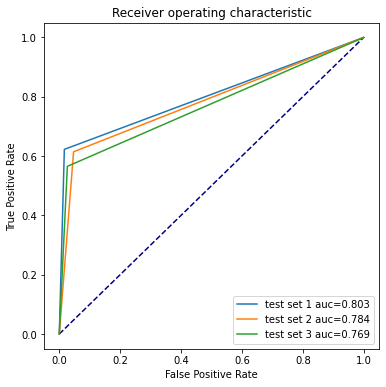

In [ ]:
fprs, tprs, aucs = [], [], [] 
for y_pred, y_true in zip(y_preds, y_trues) : 
  fpr, tpr, _ = roc_curve(y_true, y_pred) 
  auc = roc_auc_score(y_true, y_pred) 
  fprs.append(fpr) 
  tprs.append(tpr) 
  aucs.append(auc) 


plt.figure(figsize = (6,6))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
for fpr, tpr, auc, name in zip(fprs, tprs, aucs, test_df_names):
  plt.plot(fpr,tpr,label="{} auc={}".format(name, str(round(auc, 3))))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4)
plt.show()

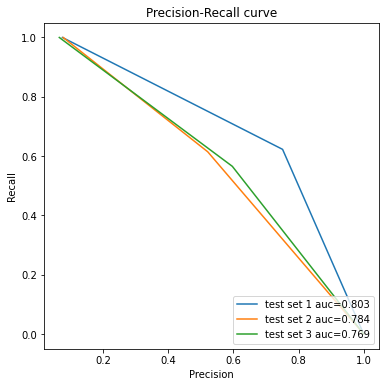

In [ ]:
precisions, recalls, aucs = [], [], [] 
for y_pred, y_true in zip(y_preds, y_trues) : 
  precision, recall, _ = precision_recall_curve(y_true, y_pred) 
  auc = roc_auc_score(y_true, y_pred) 
  precisions.append(precision) 
  recalls.append(recall)  
  aucs.append(auc) 


plt.figure(figsize = (6,6))
for precision, recall, auc, name in zip(precisions, recalls, aucs, test_df_names):
  plt.plot(precision, recall,label="{} auc={}".format(name, str(round(auc, 3))))

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.legend(loc=4)
plt.show()

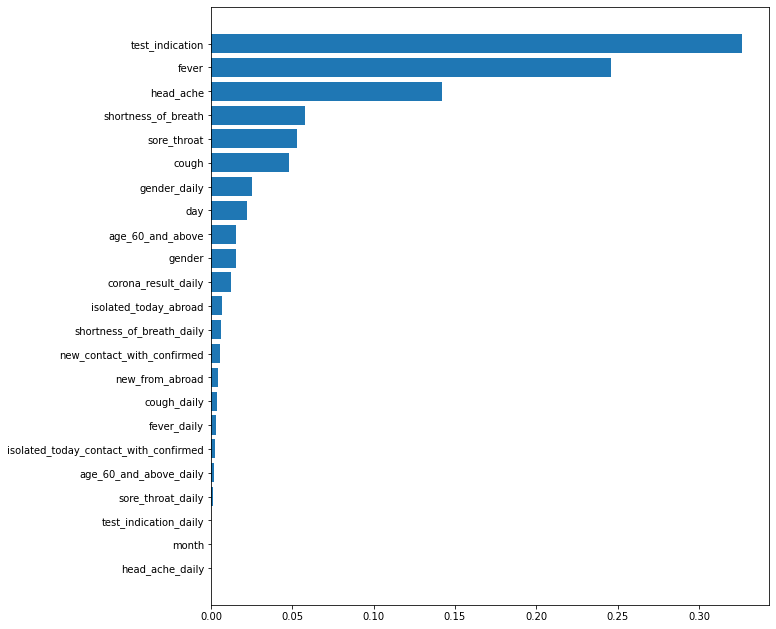

In [ ]:

importances, features = zip(*sorted(zip(xgb_model.feature_importances_, train_ds_new['features'])))
plt.figure(figsize = (10,11))
plt.barh(features, importances);

In [ ]:
import shap 
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(train_ds_new['x'])

In [ ]:
model = XGBClassifier().fit(train_ds_new['x'], train_ds_new['y'])
model.get_booster().feature_names = train_ds_new['features']
explainer = shap.Explainer(model)
shap_values = explainer(train_ds_new['x'])


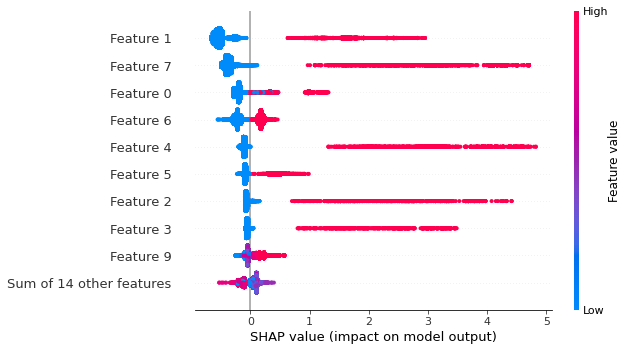

In [ ]:
shap.plots.beeswarm(shap_values)

# KNN

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# fit model no training data
knnmodel = KNeighborsClassifier(n_neighbors=3)
train_ds_new = prepare_old_dataset(train_df) 
knnmodel.fit(train_ds_new['x'], train_ds_new['y'])

test_df_names = ['test set 1', 'test set 2', 'test set 3']
test_dfs = [test1_df, test2_df, test3_df] 
y_preds, y_trues = [], []
for test_df_name, test_df in zip(test_df_names, test_dfs) : 
  test_ds = prepare_old_dataset(test_df) 
  y_pred = knnmodel.predict(test_ds['x']) 
  y_preds.append(y_pred) 
  y_trues.append(test_ds['y']) 

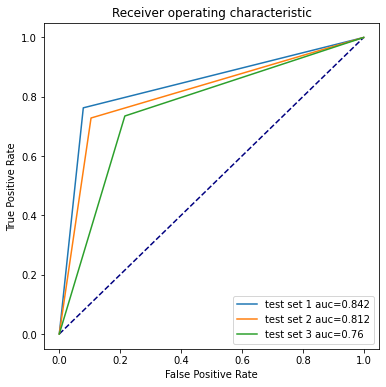

In [ ]:
fprs, tprs, aucs = [], [], [] 
for y_pred, y_true in zip(y_preds, y_trues) : 
  fpr, tpr, _ = roc_curve(y_true, y_pred) 
  auc = roc_auc_score(y_true, y_pred) 
  fprs.append(fpr) 
  tprs.append(tpr) 
  aucs.append(auc) 


plt.figure(figsize = (6,6))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
for fpr, tpr, auc, name in zip(fprs, tprs, aucs, test_df_names):
  plt.plot(fpr,tpr,label="{} auc={}".format(name, str(round(auc, 3))))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4)
plt.show()

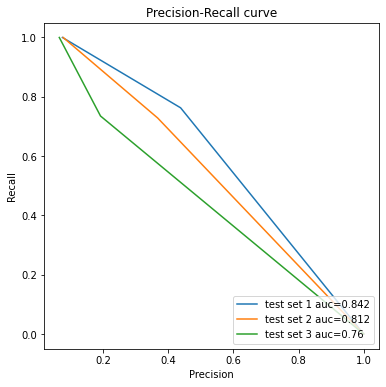

In [ ]:
precisions, recalls, aucs = [], [], [] 
for y_pred, y_true in zip(y_preds, y_trues) : 
  precision, recall, _ = precision_recall_curve(y_true, y_pred) 
  auc = roc_auc_score(y_true, y_pred) 
  precisions.append(precision) 
  recalls.append(recall)  
  aucs.append(auc) 


plt.figure(figsize = (6,6))
for precision, recall, auc, name in zip(precisions, recalls, aucs, test_df_names):
  plt.plot(precision, recall,label="{} auc={}".format(name, str(round(auc, 3))))

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.legend(loc=4)
plt.show()

# LightGBM

In [ ]:


params = {
    'task':'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}


train_names = ['old features', 'new features']
features = [old_x_features, new_x_features] 
test_df_names = ['test set 1', 'test set 2', 'test set 3']
test_dfs = [test1_df, test2_df, test3_df] 

train_dss = [prepare_lgb_dataset(train_df, old_features = True), prepare_lgb_dataset(train_df)]
test_dss = [prepare_lgb_dataset(test_dfs[0], old_features = True), prepare_lgb_dataset(test_dfs[0])]
res = [{}, {}]
y_predss, y_trues = [[], []], [] 



for i, (train_name, train_ds, test_ds) in enumerate(zip(train_names, train_dss, test_dss)):
  gbm = lgb.train(params, train_ds, num_boost_round = 1000, 
                  valid_sets = [test_ds], valid_names = ['valid'], 
                  evals_result = res[i], verbose_eval = 100) 

  for test_df_name, test_df in zip(test_df_names, test_dfs) : 
    test_ds = prepare_old_dataset(test_df) if 'old' in train_name.lower() else prepare_new_dataset(test_df) 
    y_pred = gbm.predict(test_ds['x']) 
    y_predss[i].append(y_pred) 
    y_trues.append(test_ds['y']) 
  


[100]	valid's auc: 0.90102	valid's binary_logloss: 0.135665
[200]	valid's auc: 0.900987	valid's binary_logloss: 0.136041
[300]	valid's auc: 0.900951	valid's binary_logloss: 0.13612
[400]	valid's auc: 0.900935	valid's binary_logloss: 0.136309
[500]	valid's auc: 0.900899	valid's binary_logloss: 0.13638
[600]	valid's auc: 0.90091	valid's binary_logloss: 0.136487
[700]	valid's auc: 0.9009	valid's binary_logloss: 0.136479
[800]	valid's auc: 0.900904	valid's binary_logloss: 0.136602
[900]	valid's auc: 0.900904	valid's binary_logloss: 0.136687
[1000]	valid's auc: 0.900919	valid's binary_logloss: 0.136691
[100]	valid's auc: 0.89738	valid's binary_logloss: 0.137404
[200]	valid's auc: 0.898331	valid's binary_logloss: 0.137073
[300]	valid's auc: 0.898644	valid's binary_logloss: 0.137737
[400]	valid's auc: 0.89941	valid's binary_logloss: 0.137835
[500]	valid's auc: 0.898123	valid's binary_logloss: 0.137797
[600]	valid's auc: 0.899379	valid's binary_logloss: 0.137782
[700]	valid's auc: 0.899701	val

In [ ]:

fprss, tprss, aucss1 = [], [], [] 

for y_preds in y_predss : 
  fprs, tprs, aucs = [], [], [] 
  for y_pred, y_true in zip(y_preds, y_trues) : 
    fpr, tpr, _ = roc_curve(y_true, y_pred) 
    auc = roc_auc_score(y_true, y_pred) 
    fprs.append(fpr) 
    tprs.append(tpr) 
    aucs.append(auc) 

  fprss.append(fprs) 
  tprss.append(tprs) 
  aucss1.append(aucs) 

In [ ]:
precisionss, recallss, aucss2 = [], [], [] 

for y_preds  in y_predss : 
  precisions, recalls, aucs = [], [], [] 
  for y_pred, y_true in zip(y_preds, y_trues) : 
    precision, recall, _ = precision_recall_curve(y_true, y_pred) 
    auc = average_precision_score(y_true, y_pred) 
    precisions.append(precision) 
    recalls.append(recall)  
    aucs.append(auc) 
  
  precisionss.append(precisions) 
  recallss.append(recalls) 
  aucss2.append(aucs) 

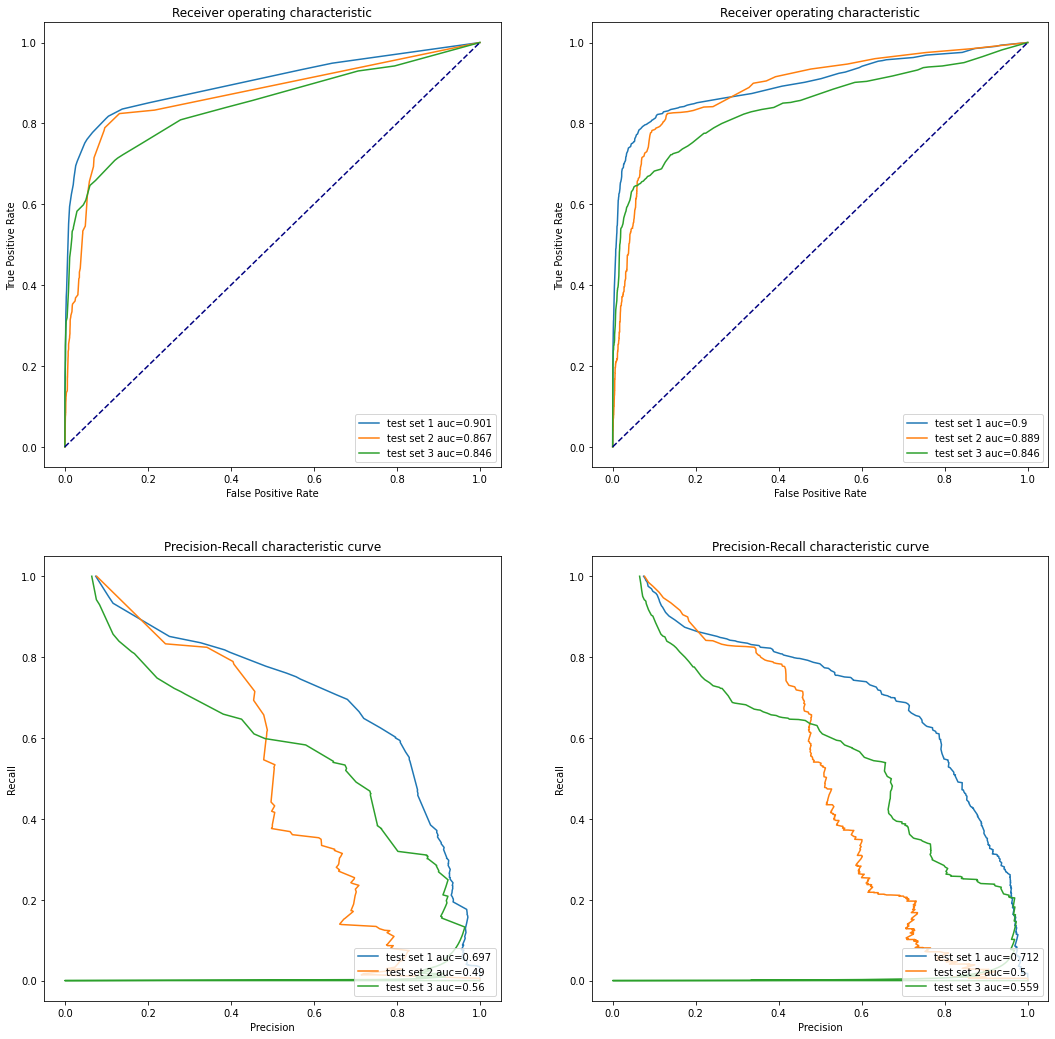

In [ ]:
# creating grid for subplots
fig = plt.figure(figsize=(18, 18))

# create two plots side by side
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0)) # loc = (row, column)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 0))
ax4 = plt.subplot2grid(shape=(2, 2), loc=(1, 1))
grids = [ax1, ax2, ax3, ax4]

for i in range(len(fprss)): 
  plt.sca(grids[i]) 
  fprs, tprs, aucs = fprss[i], tprss[i], aucss1[i] 
  for fpr, tpr, auc, name in zip(fprs, tprs, aucs, test_df_names):
    plt.plot(fpr,tpr,label="{} auc={}".format(name, str(round(auc, 3))))
  plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc=4)

for i in range(len(precisionss)) : 
  plt.sca(grids[i +2]) 
  precisions, recalls, aucs = precisionss[i], recallss[i], aucss2[i] 
  for precision, recall, auc, name in zip(precisions, recalls, aucs, test_df_names) : 
    plt.plot(precision, recall, label = "{} auc={}".format(name, str(round(auc, 3))))

  plt.xlabel('Precision')
  plt.ylabel('Recall')
  plt.title('Precision-Recall characteristic curve')
  plt.legend(loc=4)

plt.show()





In [ ]:
fprs, tprs, aucs = [], [], [] 
for y_pred, y_true in zip(y_preds, y_trues) : 
  fpr, tpr, _ = roc_curve(y_true, y_pred) 
  auc = roc_auc_score(y_true, y_pred) 
  fprs.append(fpr) 
  tprs.append(tpr) 
  aucs.append(auc) 


plt.figure(figsize = (6,6))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
for fpr, tpr, auc, name in zip(fprs, tprs, aucs, test_df_names):
  plt.plot(fpr,tpr,label="{} auc={}".format(name, str(round(auc, 3))))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4)
plt.show()

In [ ]:
precisions, recalls, aucs = [], [], [] 
for y_pred, y_true in zip(y_preds, y_trues) : 
  precision, recall, _ = precision_recall_curve(y_true, y_pred) 
  auc = roc_auc_score(y_true, y_pred) 
  precisions.append(precision) 
  recalls.append(recall)  
  aucs.append(auc) 


plt.figure(figsize = (6,6))
for precision, recall, auc, name in zip(precisions, recalls, aucs, test_df_names):
  plt.plot(precision, recall,label="{} auc={}".format(name, str(round(auc, 3))))

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.legend(loc=4)
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
 
  
fig = plt.figure(figsize = (15, 11))

# creating the bar plot
importances, features = zip(*sorted(zip(gbm.feature_importances, train_ds_new['features'])))
plt.barh(features, importances, color ='gray')

plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.title("LightGB feature contributions")
plt.show()


In [ ]:
features 

# EDA

In [ ]:
train_df = df4.query("month == 3 and day > 21")
test1_df = df4.query("month == 4 and day < 8")
test2_df = df4.query("month == 3 and day < 22")
test3_df = df4.query("month == 4 and day > 7")

In [ ]:
df4.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'corona_result', 'age_60_and_above', 'gender', 'test_indication',
       'month', 'day', 'isolated_today_contact_with_confirmed',
       'isolated_today_abroad', 'new_contact_with_confirmed',
       'new_from_abroad', 'cough_daily', 'fever_daily', 'sore_throat_daily',
       'shortness_of_breath_daily', 'head_ache_daily', 'corona_result_daily',
       'age_60_and_above_daily', 'gender_daily', 'test_indication_daily'],
      dtype='object')

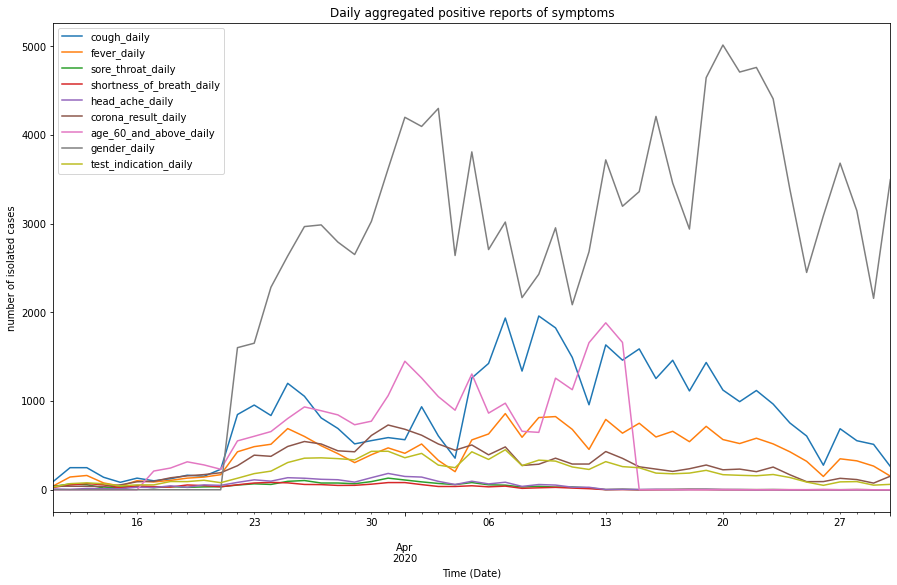

In [ ]:
params = {
    'title': 'Daily aggregated positive reports of symptoms',
    'xlabel': 'Time (Date)', 
    'ylabel': 'number of isolated cases',
    'figsize': (15, 9)
}
d_df.drop(columns = ['day_daily']).plot(**params);

Text(0, 0.5, 'Positive rate')

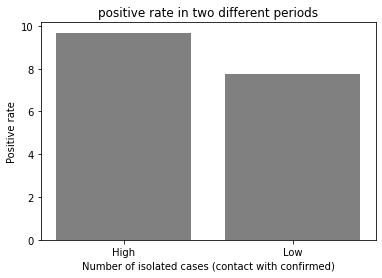

In [ ]:
isolation_threshold = df2.isolated_today_contact_with_confirmed.max() * 0.9
group1 = df4.loc[df4.isolated_today_contact_with_confirmed >= isolation_threshold]
group2 = df4.loc[df4.isolated_today_contact_with_confirmed < isolation_threshold]

params = {
    'title': 'Daily aggregated positive reports of symptoms',
    'xlabel': 'Time (Date)', 
    'ylabel': 'number of isolated cases',
    'figsize': (15, 9)
}
plt.bar(['High', 'Low'], [group1.corona_result.mean()*100, group2.corona_result.mean()*100], color = 'gray');
plt.title('positive rate in two different periods')
plt.xlabel('Number of isolated cases (contact with confirmed)')
plt.ylabel('Positive rate')